In [1]:
!pip install -q torchinfo

In [2]:
!which python

/Users/calebstone/Desktop/Pytorch/.conda/bin/python


In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
#Set seed for reproducibilty
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
       torch.cuda.manual_seed(seed)
       torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seed(42)

In [5]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

In [ ]:
!unzip -q "10_Monkey_Species.zip"

replace 10_Monkey_Species/monkey_labels.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
      ''' Configuration for Training '''
      batch_size: int = 32
      num_epochs: int = 100
      learning_rate: float = 1e-4

      log_interval: int = 1
      test_interval: int = 1
      data_root: int = "./"
      num_workers: int = 5
      device: str = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)

Available Device:  cpu


In [ ]:
train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join(train_config.data_root, "10_Monkey_Species", "validation", "validation")

In [ ]:
df = pd.read_csv(os.path.join("10_Monkey_Species","monkey_labels.txt"), sep=",", header=None)
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [ ]:
mean = [0.4368, 0.4336, 0.3294]  #mean and std of this Monkey Species dataset this block makes images immune to brightness changes
std = [0.2457, 0.2413, 0.2447]


img_size = (224,224)

preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

In [ ]:
common_transforms = transforms.Compose( # this is data augmentation for val and test sets which makes the model mor robust
    [
        preprocess,
        transforms.Normalize(mean=mean,std=std)
    ]
)

train_transforms = transforms.Compose(
    [
        preprocess,
        transforms.RandomHorizontalFlip(),

        transforms.RandomErasing(p=0.4),
        transforms.RandomApply([
        transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
         ], p =0.1),

        transforms.Normalize(mean = mean,std = std)
    ]
)

In [ ]:
#Apply augmentations to the training dataset
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)

# The validation dataset should have only common transforms like Resize, ToTensor and Normalize.
val_data = datasets.ImageFolder(root=val_root, transform = common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [ ]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [ ]:
len(train_data)

1097

In [ ]:
# def get_mean_std(train_loader, img_size=(224, 224), num_workers=2):

#     batch_mean = torch.zeros(3)
#     batch_mean_sqrd = torch.zeros(3)

#     for batch_data, _ in train_loader:
#         batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
#         batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

#     mean = batch_mean / len(train_loader)

#     var = (batch_mean_sqrd / len(train_loader)) - (mean**2)

#     std = var**0.5
#     print("mean: {}, std: {}".format(mean, std))

#     return mean, std

# train_data_mean_calc = datasets.ImageFolder(root=train_root, transform = preprocess)
# train_loader_mean_calc = DataLoader(train_data_mean_calc, shuffle = True, batch_size = training_config.batch_size, num_workers = train_config.num_workers)
# mean, std = get_mean_std(train_loader_mean_calc)

# print("Mean of Dataset: ", mean)
# print("Std of Dataset: ", std)

In [ ]:
train_loader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)
val_loader = DataLoader(
    val_data,
    shuffle = False,
    batch_size = train_config.batch_size,
    num_workers = train_config.num_workers
)

In [ ]:
len(next(iter(train_loader)))

2

In [ ]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

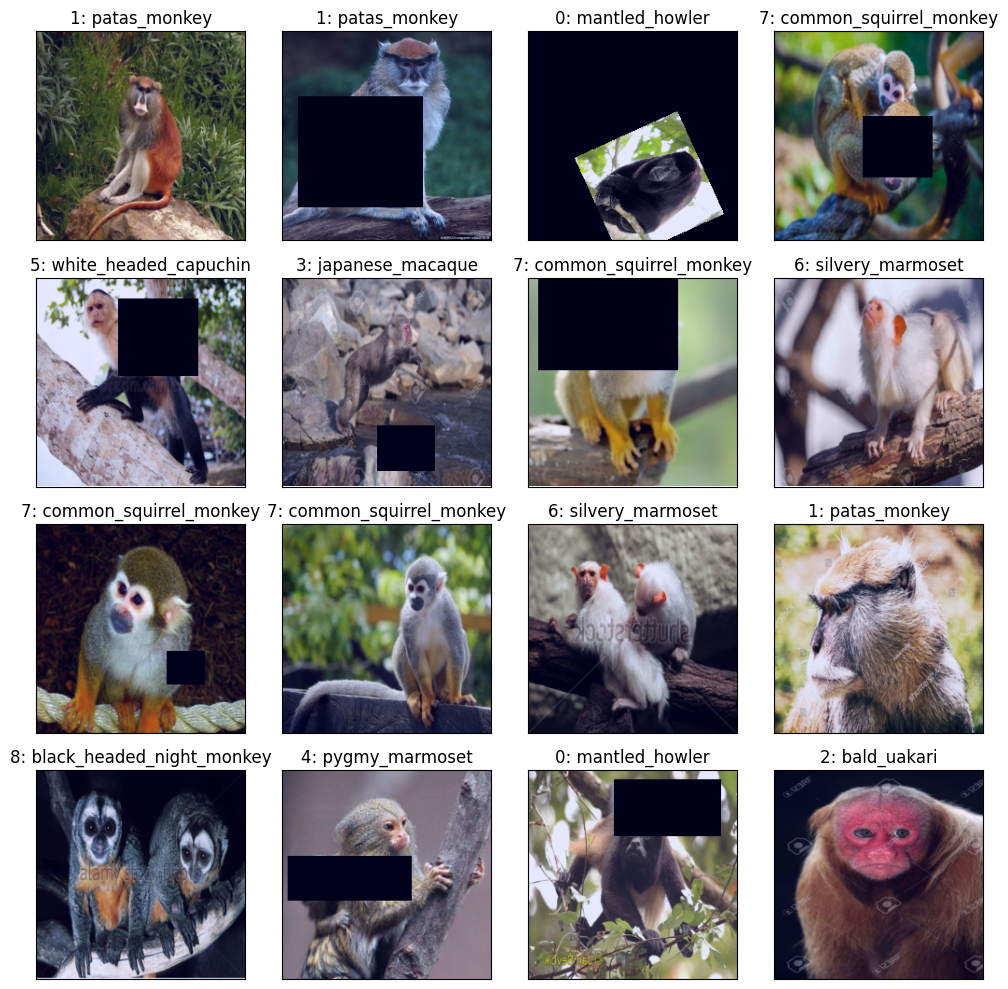

In [ ]:
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #Iterate over the first batch
    images, labels = next(iter(dataloader))
    # print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]


        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0)

        #Normalize the image to [0,1] to display

        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # remove the batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images = 16)

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()

    self._model = nn.Sequential(

        #---------------------- Convolution Layers ----------------------

        #-----------------------------------------------
        # Conv2d Norm Activation Block1: 32 Filters, MaxPool.
        #-----------------------------------------------
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace = True),

        nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2),

        #-------------------------------------------------------------------
        # Conv2d Norm Activation Block 2: 64,128 Filters, MaxPool, Dropout(p=0.25)
        #-------------------------------------------------------------------
        nn.LazyConv2d(out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),

        nn.LazyConv2d(out_channels = 128, kernel_size = 3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2),

        #--------------------------------------------------
        # Conv2d Norm Activation Block 3: 128,256,512 Filters, MaxPool.
        #--------------------------------------------------
        Conv2dNormActivation(in_channels = 128, out_channels=256, kernel_size = 3), #This is a more compact way of writing Conv2d + BatchNorm + ReLU

        Conv2dNormActivation(in_channels = 256, out_channels=256, kernel_size = 3),
        nn.MaxPool2d(kernel_size = 2),

        Conv2dNormActivation(in_channels = 256, out_channels=512, kernel_size = 3),
        nn.MaxPool2d(kernel_size = 2),

        #---------------------- Feed Forward Layers --------------------
        nn.AdaptiveAvgPool2d(output_size=(3,3)),

        #------------------------------------
        # Flatten the convolutional features.
        #------------------------------------
        nn.Flatten(),

        #--------------------
        # Classification Head.
        #--------------------
        nn.Linear(in_features = 512*3*3, out_features = 256),
        nn.Linear(in_features = 256, out_features = 10)
    )

  def forward(self,x):
      return self._model(x)

In [ ]:
model = MyModel()

optimizer  = Adam(model.parameters(), lr = train_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

logdir = "runs/80epochs-3.3M_param_dropout"

writer = SummaryWriter(logdir)

dummy_input = (1,3,224,224)
print(summary(model, dummy_input, row_settings = ["var_names"],device="cpu"))

Layer (type (var_name))                  Output Shape              Param #
MyModel (MyModel)                        [1, 10]                   --
├─Sequential (_model)                    [1, 10]                   --
│    └─Conv2d (0)                        [1, 32, 220, 220]         2,432
│    └─BatchNorm2d (1)                   [1, 32, 220, 220]         64
│    └─ReLU (2)                          [1, 32, 220, 220]         --
│    └─Conv2d (3)                        [1, 32, 218, 218]         9,248
│    └─BatchNorm2d (4)                   [1, 32, 218, 218]         64
│    └─ReLU (5)                          [1, 32, 218, 218]         --
│    └─MaxPool2d (6)                     [1, 32, 109, 109]         --
│    └─Conv2d (7)                        [1, 64, 107, 107]         18,496
│    └─BatchNorm2d (8)                   [1, 64, 107, 107]         128
│    └─ReLU (9)                          [1, 64, 107, 107]         --
│    └─Conv2d (10)                       [1, 128, 105, 105]        73,856


In [ ]:
def train(model, train_loader):
    model.train()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_train_samples
    return train_avg_loss, train_accuracy

In [ ]:
def validation(model, val_loader):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_val_samples = 0

    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
             outputs = model(images)

        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_val_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    val_avg_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_predictions / total_val_samples
    return val_avg_loss, val_accuracy

In [ ]:
def main(model, train_loader, val_loader):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_weights = None

    for epoch in range(train_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = validation(model, val_loader)


        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to tensorboard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights =  model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

NameError: name 'main' is not defined

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,train_config.num_epochs + 1), train_losses, label = "Train Loss")
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,train_config.num_epochs + 1), train_accuracies, label = "Train Accuracy")
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load("best.pt"))
model.eval()

In [ ]:
def prediction(model, val_loader):

    model.eval()
    model.to(DEVICE)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []

    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.inference_mode():
             outputs = model(images)

        prob = F.softmax(outputs,dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())


    return (torch.cat(all_images).numpy(),
            torch.cat(all_labels).numpy(),
            torch.cat(all_pred_indices).numpy(),
            torch.cat(all_pred_probs).numpy())

In [ ]:
def denormalize(image):
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    image = image * std_ar + mean_ar
    return np.clip(image, 0,1)

In [ ]:
def visualise_predictions(sample_images,sample_gt_labels, pred_indices, pred_probs, num_images =5):

    fig = plt.figure(figsize = (20,5))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) -1)
        image = sample_images[idx].transpose(1,2,0) #(C,H,W) --> (H,W,C)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)

        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis('off')

    plt.show()

In [ ]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images = 5)

In [ ]:
cm = confusion_matrix(y_true=val_gt_labels, y_pred = pred_indices)

plt.figure(figsize= [10,5])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()